# Oversikt over dhlab versjon 0.75

Her følger litt info om dagens DHlab, som kan hjelpe litt i planleggingen videre. Mer enn det som er strengt tatt nødvendig, men skulle dekke det meste - ikke alt. Samtidig gis det litt kontekst for noe av funksjonaliteten. Mot slutten er det med litt om det som er tilgjengelig på db1 av metadata og konkordans. 

Selv om DHlab er rettet mot et sett pythonkommandoer som sluttbrukere kan benytte, bør vi nok se mer mer på mulighetene for å lage apper i skyen (les GCP), spesielt med Streamlit. Det har vært litt klager på at Jupyter ikke er så brukervennlig. Men det ligger uansett ett stykke uti. Vi har en vei fra Github til GCP, som kan brukes, og som kan utvikles videre.

Modellen, eller dhlab-stacken, ser omtrent sånn ut:

&nbsp;&nbsp;&nbsp;&nbsp;server/fulltekst &rarr; api/Flask &rarr; pythonwrapper &rarr; dhlabkode/notebook &rarr; apper/Streamlit

Koden for dhlab ligger i et pypi-repo med det passende navnet dhlab, som består av fire moduler, nbtext, module_update, nbpicture, graph_networkx_louvain, pluss en del ekstra kode som har kommet til i ettertid. Vi kan rydde litt opp i versjonsnummer og få det hele på stell, med regelmessige oppdateringer etter hvert.

Nedenfor tar jeg med det som kan tenkes å bli innarbeidet i neste versjon av dhlab (0.8?), vi har allerede startet diskusjonen om mer funksjonalitet. Noe av koden er tenkt å utføres på server, og noe lokalt på en klientmaskin, så her er det med litt av begge deler. 

Noe av beregningene nedenfor, som kollokasjon- og nøkkelordsanalyse, er mest for å vise gangen og logikken i det hele, og hvordan dataene som kommer fra dhlab kan benyttes. Ikke minst at det som hentes ut kan enkelt integreres med redskap utenfor dhlaben selv. 

Til slutt i dokumentet summeres opp de kommandoene som skal gå på serversiden, og som det trengs implementasjon for. En del av de tingene som gjøres lokalt på klientsiden i dag, kan om mulig flyttes til serversiden, som for eksempel en default kollokasjonsanalyse. 

Til forskjell fra dagens dhlab, er det nok best å legge alle pythonwrapperne rundt APIet i en egen modul, som andre kan bygge på. Da vil den pythonkoden også mer eller mindre automatisk kunne fungere som en dokumentasjon på APIet. Neste versjon av dhlab bygges over de wrapperne. I dagens løsning er modulene en lett blanding av wrappere og utvidet kode.



### Importer modulene

In [42]:
import dhlab.nbtext as nb
import dhlab.module_update as mu
import dhlab.graph_networkx_louvain as gnl
import dhlab.nbpictures as np
from dhlab.nbtokenizer import tokenize 

Modulen `mu` har litt funksjonalitet som å hente nye moduler, toggle kode og sånn. Og sette CSS. Den er fin for å benytte utvidelser, kode som ikke er med i pypi. Det er en kommando `mu.update`, som laster ned moduler fra Github

In [185]:
mu.css()

In [188]:
# APIet mot ordbanken ble endret underveis, og oppdatert versjon kan lastes ned med hjelpekommando

mu.update('wordbank')
import wordbank as wb

Updated file `C:\Users\larsj\Documents\GitHub\Miscellaneous-Notebooks\DHLab_text\wordbank.py`

In [44]:
# Av og til kan det være greit å skjule koden

#mu.code_toggle()

Jupyter notebook har også muligheten til å manipulere CSS direkte. I tillegg til mu.css(). 

In [195]:
%%HTML
<style>
p {
    font-size:1.4em;
    line-height:1.5em;
    color:#142850;
}
h1, h2, h3, h4 {
    color:#27496d;
}

.prompt {
    visibility: hidden; /* skjuler In [] og Out [] - fjern om du skal kjøre... */
}

.input_area, .output_area {
    margin-left:2.5em;
    margin-right:2.5em;
}
</style>

# Modulen `nb` 

Her ligger det meste av kommandoer for tekstbehandling som konkordans og kollokasjon, og statistikk fra bøker. 

Det ligger en del kode i moduler som er utviklet i etterkant også. I prinsippet kan all kode lastes inn i etterkant fra Github. 

Det vi først og fremst skal gjøre er å hente ut informasjon om ord og tekster fra et korpus.  Korpuset vil typisk være et sett referanser til dokumenter i form av en liste av URN-er (eller reduserte URN-er). URN-ene kan være implisitt eller eksplisitt. Så korpus-begrepet er litt forskjellig fra det man er vant til. Det å lage et korpus i dhlab-forstand betyr å velge et sett URNer fra NBs digitaliserte materiale.

Kommando for å søke etter URNer er fasettert slik at forfattere markeres med 'author', emneord med 'subject', ett for hver type fasett eller parameter. Mekanismen og indekseringen for de nye metadata er noe forskjellig, men kommandoene som møter brukeren vil være noenlunde lik.

# Konkordans, kollokasjon og nøkkelord

All logikken og arbeidet med kommandoer er modellert sånn at spørringer mot korpus alltid er ledsaget av en (ingen) eller flere URNer sammen med andre parametre. For å bygge et korpus brukes `nb.book_corpus`. For noen av parametrene til book_corpus bør det brukes jokertegn.

In [131]:
korpus = nb.book_corpus(ddk = '4%', subject='syntaks', lang='nob', limit = 100)

Det er flere kommandoer for å generere korpus, der _book_corpus_ er kanskje å foretrekke, og ligner mest på den som går mot db1. Den gir en dataramme med grunnleggende informasjon

In [132]:
korpus.head(10)

,urn,author,title,year
0,2008060904023,"Vinje, Finn-Erik",Moderne norsk,1979
1,2007072704045,,Sentrale problemer i norsk syntaks,1977
2,2011032408050,"Sollid, Hilde",Dialektsyntaks i Nordreisa,2003
3,2006120801095,"Western, Aug.",Norsk riksmåls-grammatikk,1921
4,2007082004014,"Simonsen, Hanne Gram",norsk femårings språkbruk,1983
5,2016011108217,"Vinje, Finn-Erik",Moderne norsk,2002
6,2008052000058,"Næs, Olav",Norsk grammatikk,1965
7,2008060204083,"Vannebo, Kjell Ivar",Tempus og tidsreferanse,1979
8,2008060404081,"Hanssen, Eskil",Avbrutte setninger i talemål,1983
9,2008072904018,"Brautaset, Anne",Inversjon i norsk mellomspråk,1996


Korpuset kan også bygges fra teksten selv, her illustrert med bøker som innholder ordet _arbeidsledighet_. 

In [192]:
nb.book_corpus(words = ['arbeidsledighet'], limit = 5)

,urn,author,title,year
0,2014062006108,"Tjomsland, Audun",personlig reise i Amerika fra Kennedy til Obama,2008
1,2012121208009,"Seim, Torstein Stiegler",Balkanlabyrinter,2010
2,2015032508141,,Nordnorsk utsyn,2000
3,2011011208169,,Høyres programkomité inviterer til Åpent parti,1996
4,2011080108009,"McDermid, Val",Ekko i det fjerne,2005


Bøker skrevet av kvinner

In [194]:
nb.book_corpus(words = ['arbeidsledighet'], gender = 'f', subject = 'kvinner', limit = 5)

,urn,author,title,year
0,2009072300047,"Kjeldstad, Randi",Kvinner og menn i deltidsarbeid,2004
1,2016040408039,"Soknes, Torun Segtnan",Erobringen av en mannsbastion,2000
2,2011052308100,"Wiig, Birgit",Kvinner selv,1984
3,2013061006056,"Moen, Hilde Berit",I spenningsfeltet mellom personlig identitet o...,2010
4,2011070405166,"Gade, Hege",Hjelper til Perspektiver på ledelse,2004


For å gjøre søk med URN, legges de til fra datarammen sammen med et søkeord. Herfra skal vi benytte korpuset bygd over, og som ligger i variabelen `korpus`. Et problem for dhlab er fravær av et skikkelig system for å behandle korpus, og URNer. Hjelpekommandoen `nb.pure_urn` tar det meste av datastrukturer og prøver å finne URNer i dem. Må brukes for å få kommandoene til å virke. Men her kan vi tenke oss å lage et klassesystem à la `nb.Corpus`.

In [142]:
nb.urn_concordance(word = 'ergativ', urns = nb.pure_urn(korpus), before = 10, after = 10, size=2)

"Kontrastiv grammatikk - med norsk i sentrum, Lie, Svein, 1990",) er det slik at subjektet står i oblik (,ergativ,") , mens objektet står i direkte kasus ( absolutiv"
"Innføring i språkvitenskap, , 1998","transitive setninger står da i en egen kasus , kalt",ergativ,. Subjektet i intransitive setninger og objektet i transitive setninger
"Innføring i språkvitenskap, , 1998","et slikt språk er indianerspråket zoque i Mexico , der",ergativ,får endelsen - is og absolutiv får ingen endelse .
"Innføring i språkvitenskap, , 1998",I a ) står reyis ' konge ' i,ergativ,"siden det er subjektet i en transitiv setning , mens"


Kollokasjoner har tilsvarende kommando, som gir en liste av ord som kan bearbeides. I og med at resultatet er en dataramme går det fint å implementere en leksemkollokasjon bare ved å repetere øvelsen med flere ord, og legge sammen resultatene. 

In [145]:
coll = nb.urn_coll(word='transformasjonell', urns =nb.pure_urn(korpus))
coll

,0
generativ,31
grammatikk,23
",",22
en,21
.,17
...,...
ekstraponering,1
eldre,1
eller,1
enn,1


Normaliserer datarammen, men her er det flere muligheter for normalisering - alt avhengig av hva som skal gjøres.

In [196]:
nb.normalize_corpus_dataframe(coll);

Bearbeiding med kollokasjoner kan benytte frekvenslister for hele boksamlingen som referanse. Husk at kollokasjon kan sees på som en tolkning av formelen

$$\frac{p(w|C)}{p(w)}$$

Der $p(w)$ er sannsynligheten (eller proporsjonen) av ordet $w$ i totalkorpuset, og $p(w|C)$ er den betingede sannsylighet (proporsjon) for $w$ i ordlisten $C$, som kan komme fra en kollokasjon eller et annet korpus. Om verdien er 1  har $w$ identisk distribusjon i helheten som i korpuset. Jo lengre fra 1 desto mer relevant er $w$ for $C$. I alle fall så lengde frekvensen til $w$ er av en viss størrelse. 


Kommandoen `nb.totals()` bygges inn i `nb.frame()` som er en wrapper rundt pandas datarammekonstruktør

In [197]:
tot = nb.frame(nb.totals(200000), 'tot')
nb.normalize_corpus_dataframe(tot);

De mest relevant ordene for kollokasjonen i korpuset finnes ved å dividere målfrekvensene på frekvensene i referansen. Andre statistikker er mulige, men den her er rimelig enkel å forklare og forstå visuelt - som stolpediagram vil de viktige ordene være de som har høyere stolpediagram i korpuset (frekvenslisten) enn de i referansen.  Merk at normaliseringen vi bruker (prosentkalkyle), vil jekke opp tallene noe, rett og slett fordi det er litt færre i korpuset. Men sorteringen av tallene vil være det samme som om det hadde vært tatt høyde for størrelsen. Normaliseringen gjør det lettere å tolke også. Men hva som er et høyt tall vil avhenge litt av frekvensen. 

In [148]:
nb.frame_sort(nb.frame(coll[0]/tot.tot)).head(10)

,0
generativ,322555.705448
Verbets,23374.515768
grammatikk,15396.387632
analysemetoden,13299.293454
innføringsbok,13107.205103
flytning,10521.521164
toverdig,8666.955285
transformasjoner,7062.649355
valens,6013.713776
syntaks,5718.948170


##### Kobling til formel

Uttrykket $\frac{\textrm{koll}[0]}{\textrm{tot.tot}}$ har koblingene til formelen over som $p(w) \sim \textrm{tot.tot}$ og $p(w|C) \sim \textrm{koll}[0]$. Pandas skjuler variabelen $w$. En litt mer presis formulering ville vært å skrive $p(w|U)$ for $p(w)$ og $p(w|C,U)$ for $p(w|C)$, der $U$ står for den mest generelle konteksten. Merk at om $C$ er del av $U$ vil $p(w|C,U)$ være ekvivalent med $p(w|C)$. Da blir pandas-formelen ganske enkelt $\frac{C}{U}$. 

Samme metode for å analysere hele korpuset. Kommando/funksjon for å hente ut summen av alle ord i korpuset er `nb.aggregate_urns`

In [198]:
korpus_total = nb.frame(nb.aggregate_urns(nb.pure_urn(korpus)))
nb.normalize_corpus_dataframe(korpus_total);

In [150]:
nb.frame_sort(korpus_total).head(5)

,0
",",0.046649
.,0.046159
i,0.021382
),0.020365
(,0.018881


Nøkkelordene for korpuset beregnes likedan som for kollokasjonen, en frekvensliste. 

In [199]:
korpus_keys = nb.frame_sort(nb.frame(korpus_total[0]/tot.tot))
korpus_keys.head(10)

,0
Arbbl,1281.631952
leddsetningen,834.641127
relativsetninger,688.434490
Hkr,674.293617
finitt,646.303197
relativsetning,545.237416
spørresetninger,516.487162
finitte,510.732801
morfemer,478.508572
predikativ,468.463781


En annen kommando for å hente URNer er `nb.best_book_urn` som finner den beste gitt en sammenligning av ordet med alt annet i boksamlingen. Den funksjonen fordrer en bearbeiding av ordlistene med tilhørende indeksering.

In [200]:
nb.frame(nb.best_book_urn(word="Chomsky"), "urn forfatter tittel år".split()).head(5)

,urn,forfatter,tittel,år
0,2008052304018,"Hiorth, Finngeir",Noam Chomsky,1974
1,2009021604003,"Hovdhaugen, Even",Transformasjonell generativ grammatikk,1971
2,2008061900083,"Anderssen, Merete",acquisition of functional categories,1996
3,2011022205085,"Åfarli, Tor Anders",Grammatikk - kultur eller natur?,2000
4,2016061508024,"Dyvik, Helge",Grammatikk og empiri,1980


Det er også kommandoer for å lage konkordanser uten å gå via URN, likeså for kollokasjoner. Se for eksempel notebooken https://nbviewer.jupyter.org/github/DH-LAB-NB/DHLAB/blob/master/2_Konkordans.ipynb

## Frekvenslister, nøkkelord og grafkonstruksjoner

Frekvenslister kan hentes ut for alle bøker med `nb.get_freq`. URN er redusert URN, altså bare sekvensnummeret. Her skal vi se hvordan vi kan bygge grafer og lage clustre fra dem med networkx og pandas. Først ved hjelp av frekvenslister på klientsiden, og deretter på serversiden ved å bruke funksjonen `nb.make_network_graph`.

Hent ut deler av frekvensene for en bok. For å få hele listen, sett top = 0 og cutoff = 0


In [201]:
nb.frame(nb.get_freq(nb.pure_urn(korpus)[0], top = 5, cutoff = 10))

,0
.,11035
",",9270
er,4920
i,4889
),4556


Med `get_freq` kan det bygges en DTM rimelig kjapt. Hvor raskt avhenger av antallet tekster.

In [154]:
import pandas as pd

Koden henter ut hele listen for de 10 første bøkene i korpuset 


In [155]:
dtm = pd.concat([nb.frame(nb.get_freq(u, top = 0, cutoff = 0), str(u)) for u in nb.pure_urn(korpus)[:10]], axis = 1)

In [156]:
dtm.head(8)

,2008060904023,2007072704045,2011032408050,2006120801095,2007082004014,2016011108217,2008052000058,2008060204083,2008060404081,2008072904018
.,11035.0,2819.0,4302.0,16921.0,3023.0,8179.0,14153.0,8820.0,507.0,2631.0
",",9270.0,2388.0,4207.0,18538.0,3257.0,13572.0,16303.0,7223.0,123.0,1784.0
er,4920.0,1346.0,2401.0,2958.0,1224.0,7136.0,4524.0,1959.0,160.0,783.0
i,4889.0,1576.0,3188.0,3672.0,1477.0,7190.0,4771.0,4817.0,178.0,1528.0
),4556.0,1876.0,1693.0,2351.0,2765.0,5811.0,4380.0,6211.0,69.0,1083.0
(,4348.0,1872.0,1661.0,1521.0,2658.0,5848.0,3828.0,6126.0,69.0,1059.0
:,4074.0,312.0,1315.0,10901.0,1899.0,5333.0,4487.0,1917.0,109.0,881.0
og,4003.0,1041.0,2515.0,3720.0,1338.0,5857.0,4110.0,2581.0,196.0,1428.0


For clustring skal vi ta kryssproduktet av bøkene, som i pandas er x.dot(y). Men vi gjør det med et utvalg ord. Her med de viktigste ordene fra hver bok. I neste celle bidrar hver bok med de 150 beste ordene til en dataramme dtm_key.

In [157]:
dtm_key = pd.concat([(dtm[x]/tot.tot).sort_values(ascending=False).head(150) for x in dtm], axis = 1)

In [158]:
dtm_key.columns = dtm.columns

Her er datarammen med nøkkelord fra hver bok

In [159]:
dtm_key.sort_values(by=dtm_key.columns[2], ascending = False).head(10).fillna(0).style.background_gradient(axis = 1)

,2008060904023,2007072704045,2011032408050,2006120801095,2007082004014,2016011108217,2008052000058,2008060204083,2008060404081,2008072904018
kvensk,0.000000,0.000000,475904437.776758,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
inversjon,0.000000,0.000000,420929394.679041,73739456.002168,21507341.333966,0.000000,55304592.001626,0.000000,0.000000,685162445.353475
primærdata,0.000000,0.000000,270574937.157048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
språkbrukere,0.000000,33408890.981143,233862236.868002,0.000000,0.000000,86863116.550972,0.000000,0.000000,0.000000,0.000000
dialekten,0.000000,0.000000,209519163.729872,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
finitte,61067777.028659,21809920.367378,200651267.379881,69791745.175611,30533888.514330,43619840.734757,34895872.587805,0.000000,4361984.073476,34895872.587805
nekting,0.000000,0.000000,191353901.970467,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Aldersgruppe,0.000000,0.000000,178918778.682446,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
språksamfunn,0.000000,0.000000,159929162.186178,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
kvenske,0.000000,0.000000,134375175.782400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [160]:
graph = dtm_key.fillna(0).dot(dtm_key.fillna(0).transpose())

Grafkonstruksjonen gir foreløpig ikke en graf, men en matrise over alle ordene (bytt om .transpose() til venstre for .dot() og det blir en tabelll over bøkene.) Matrisen kan sees på som en avstandstabell, der tallet i hver celle er avstanden mellom ordet venstre marg til ordet i headeren. Så distansen mellom _nyanse_ og _fruktig_ er $2^{17}$ ca, mens avstanden mellom _nyanse_ og _bourbon_ er litt lavere $5^{16}$. Tallene ville hatt godt av en logaritme!

In [161]:
graph.head(10)

,Arbbl,Aftp,preposisjonsuttrykk,opphavlige,sideordning,leddsetningen,infinitiven,Dagbl,vsa,relativsetning,...,tilnærmingsmåten,acquisition,Avvikende,Language,Ellis,analyseresultatene,Kollektiv,behandla,universitetsstudier,invandrare
Arbbl,3.530530e+18,7.863192e+17,6.239616e+17,5.327756e+17,4.965990e+17,4.423190e+17,4.107691e+17,3.711462e+17,3.518618e+17,3.777374e+17,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Aftp,7.863192e+17,1.943507e+17,1.731500e+17,1.266553e+17,1.701347e+17,1.384954e+17,1.270945e+17,8.515089e+16,7.714957e+16,1.200297e+17,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
preposisjonsuttrykk,6.239616e+17,1.731500e+17,2.361153e+17,1.235951e+17,2.517025e+17,1.652684e+17,1.893046e+17,7.475815e+16,5.770504e+16,1.775542e+17,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
opphavlige,5.327756e+17,1.266553e+17,1.235951e+17,9.884735e+16,1.132868e+17,9.233902e+16,8.928704e+16,5.815160e+16,5.204972e+16,8.291933e+16,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
sideordning,4.965990e+17,1.701347e+17,2.517025e+17,1.132868e+17,3.139775e+17,2.024830e+17,2.157170e+17,6.414355e+16,4.365531e+16,2.131393e+17,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
leddsetningen,4.423190e+17,1.384954e+17,1.652684e+17,9.233902e+16,2.024830e+17,1.492825e+17,1.386568e+17,5.284144e+16,4.098158e+16,1.354281e+17,...,1.293955e+14,1.258115e+14,1.254422e+14,1.253021e+14,1.249413e+14,1.233978e+14,1.217233e+14,1.205157e+14,1.182186e+14,1.152954e+14
infinitiven,4.107691e+17,1.270945e+17,1.893046e+17,8.928704e+16,2.157170e+17,1.386568e+17,1.575667e+17,5.168126e+16,3.678288e+16,1.489864e+17,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Dagbl,3.711462e+17,8.515089e+16,7.475815e+16,5.815160e+16,6.414355e+16,5.284144e+16,5.168126e+16,3.968406e+16,3.666310e+16,4.777822e+16,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
vsa,3.518618e+17,7.714957e+16,5.770504e+16,5.204972e+16,4.365531e+16,4.098158e+16,3.678288e+16,3.666310e+16,3.522699e+16,3.370138e+16,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
relativsetning,3.777374e+17,1.200297e+17,1.775542e+17,8.291933e+16,2.131393e+17,1.354281e+17,1.489864e+17,4.777822e+16,3.370138e+16,1.534136e+17,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


Samme tabell etter logaritme, og litt avrunding. Sånne linjer bør humanioraforskerene spares for. En av grunnene til å lage wrappere.

In [162]:
from math import log

In [163]:
graph.replace(0,0.1).fillna(0.1).applymap(log).head(10).applymap(lambda x: round(x,2))

,Arbbl,Aftp,preposisjonsuttrykk,opphavlige,sideordning,leddsetningen,infinitiven,Dagbl,vsa,relativsetning,...,tilnærmingsmåten,acquisition,Avvikende,Language,Ellis,analyseresultatene,Kollektiv,behandla,universitetsstudier,invandrare
Arbbl,42.71,41.21,40.97,40.82,40.75,40.63,40.56,40.46,40.40,40.47,...,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.3,-2.30
Aftp,41.21,39.81,39.69,39.38,39.68,39.47,39.38,38.98,38.88,39.33,...,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.3,-2.30
preposisjonsuttrykk,40.97,39.69,40.00,39.36,40.07,39.65,39.78,38.85,38.59,39.72,...,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.3,-2.30
opphavlige,40.82,39.38,39.36,39.13,39.27,39.06,39.03,38.60,38.49,38.96,...,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.3,-2.30
sideordning,40.75,39.68,40.07,39.27,40.29,39.85,39.91,38.70,38.32,39.90,...,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.3,-2.30
leddsetningen,40.63,39.47,39.65,39.06,39.85,39.54,39.47,38.51,38.25,39.45,...,32.49,32.47,32.46,32.46,32.46,32.45,32.43,32.42,32.4,32.38
infinitiven,40.56,39.38,39.78,39.03,39.91,39.47,39.60,38.48,38.14,39.54,...,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.3,-2.30
Dagbl,40.46,38.98,38.85,38.60,38.70,38.51,38.48,38.22,38.14,38.41,...,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.3,-2.30
vsa,40.40,38.88,38.59,38.49,38.32,38.25,38.14,38.14,38.10,38.06,...,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.3,-2.30
relativsetning,40.47,39.33,39.72,38.96,39.90,39.45,39.54,38.41,38.06,39.57,...,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.30,-2.3,-2.30


Fra matrisen hentes grafen ut med networkx, som har et api mot pandas.

In [164]:
import networkx as nx

In [165]:
G = nx.from_pandas_adjacency(graph)

Trimmer grafen ned litt, uten å kutte alt helt bort. Etter trimming tegnes grafen med `gnl.show_graph`. Den farvelegger nodene etter clustertilhørighet. Den visuelle fordelingen av nodene gjøres med Force Atlas (samme som på nb-ngram). Interessant at Louvain-clustringen stemmer ganske bra med den visuelle clustringen.

In [166]:
Gf = nx.from_edgelist([(u,v, e) for u,v,e in G.edges(data=True) if e['weight'] > 10**16])

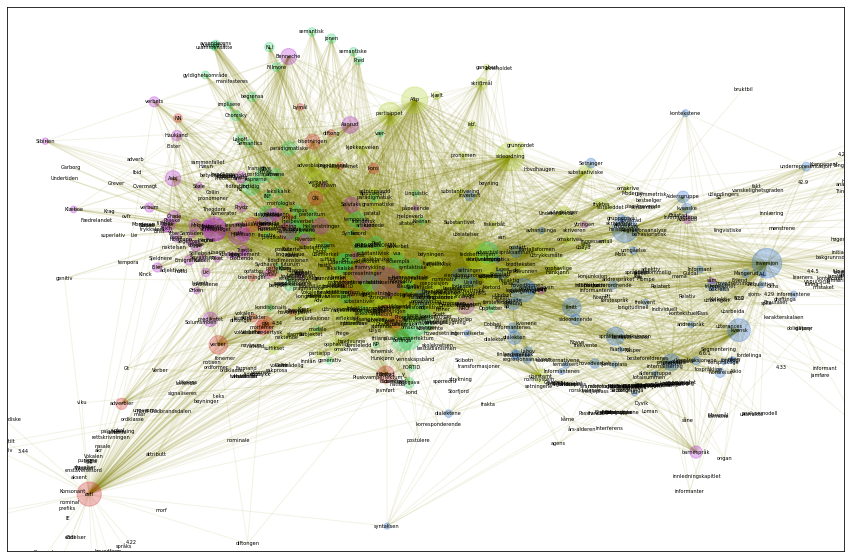

In [167]:
gnl.show_graph(Gf, spread = 2, fontsize = 5)

Clustringen blir forholdsvis grov, noe som er forventet når det gjøres på boknivå, men noe får vi ut. I og med at korpuset har en viss vilkårlig karakter vil noen clustre kanskje påvirkes av enkelte bøker.

Louvain-metoden gjør det mulig å lage subclustre om nødvendig. Nedenfor skal vi ta de viktigste nøkkelordene for korpuset og ta kryssprodukt basert på samforekomst i avsnitt.

I visning av clustre tas de to mest sentrale nodene og brukes som navn på clusteret. Det gir ofte en god hint om hva clusterte inneholder. 

In [168]:
gnl.show_communities(Gf)

leddsetningen-sideordning :  leddsetningen, sideordning, relativsetning, Aftp, preposisjonsuttrykk, infinitiven, Arbbl, opphavlige, foranstilt, predikativ, forledd, verbalet, partisippet, adverbiale, sideordnede, uttrykksmåten, forleddet, korrelat, leddsetning, Bøyning, intetkjønnsord, transitivt, Dagbl, Omskrivning, preposisjonen, sideordnet, transitiv, pronomenet, infinitivsmerket, kongruens, opphavlig, flertallsformen, flertallsform, moteord, adjektiviske, intransitivt, omskrivning, konjunksjonen, substantivet, substantiviske, ubestemt, vsa, grunnformen, sammensetninger, refleksivt, ubemerket, kjøkkenveien, preposisjon, avstikkende, avledninger, bøyningen, NRO, subjektet, fryktes, skriftmål, isere, suffikset, pronominal, omskrives, Subjektet, apposisjon, adjektivet, hevdvunnen, grammatisk, Jamfør, subjekt, grammatiske, nektende, Substantivet, adjektivisk, informasjonsstrømmen, intransitive, omskrive, substantivisk, ordbruken, innbygd, pronomenene, bøyningsformer, Berulfsen, talesprå

En annen måte å generere grafer på er å benytte serversiden for beregninger. På klientsiden er det tre muligheter for å komme nærme teksten, enten vi frekvenslister, men da er alle ordene like nær hverandre. Ellers går det fint å hente ut konkordanser og lage matriser basert på dem. På serversiden kan alt gjøres, og en operasjon implementert der, er å lage samforekomstmatriser som den over basert på hvilke avsnitt ordene opptrer i. 

Kommando for å lage grafer/nettverk er `make_network_graph`, som tar et sett ord, en URN, og lager en graf over ordene basert på samforekomst i avsnitt. Grafene for flere bøker kan kobles sammen.

Her tar vi topp-ordene ligger i toppen variabelen `korpus_keys` definert over.

In [169]:
korpus_keys.head(10)

,0
Arbbl,1281.631952
leddsetningen,834.641127
relativsetninger,688.434490
Hkr,674.293617
finitt,646.303197
relativsetning,545.237416
spørresetninger,516.487162
finitte,510.732801
morfemer,478.508572
predikativ,468.463781


Om vi velger de 200 på topp i den listen skulle vi være rimelig trygg på at vi får med relevante ord.

In [170]:
korpus_keys.head(200).iloc[199]

0    81.581856
Name: stavinga, dtype: float64

Vi lager en graf over de samme bøkene som ovenfor, de 10 første i korpuset.  Grafene konstrueres på serversiden med kommandoen `make_network_graph` som loopes over hver URN i de første ti i korpuset.

In [171]:
Gs = [nb.make_network_graph(u, list(korpus_keys.head(200).index)) for u in nb.pure_urn(korpus)[:10]]

Vi kan ta en titt på de clustringen i de tre første grafene, før de slås sammen til en stor graf nedenfor. Den første tegnes også.

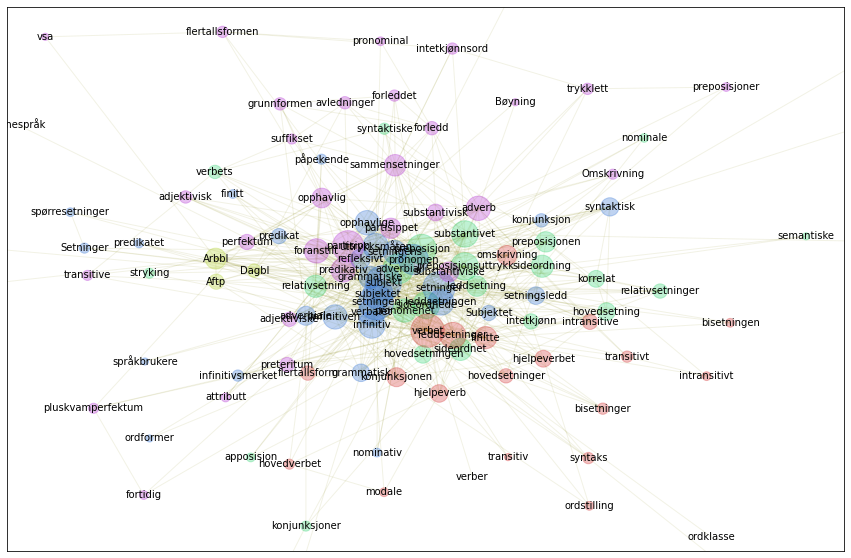

In [172]:
gnl.show_graph(Gs[0])

In [173]:
gnl.show_communities(Gs[0])

Arbbl-Aftp :  Arbbl, Aftp, Dagbl, Berulfsen

adverbial-preposisjon :  adverbial, preposisjon, preposisjonsuttrykk, sideordnede, substantivet, opphavlige, pronomenet, sideordnet, sideordning, relativsetning, preposisjonen, leddsetning, setningsledd, hovedsetningen, hovedsetning, korrelat, relativsetninger, verbets, syntaktiske, konjunksjoner, stryking, apposisjon, bisetningen, nominale, semantiske, sideordnende, ordstillingen

subjekt-setningen :  subjekt, setningen, setninger, pronomen, subjektet, verbalet, leddsetningen, uttrykksmåten, infinitiven, setningens, grammatiske, refleksivt, adverbiale, syntaktisk, grammatisk, predikat, Subjektet, syntaks, infinitivsmerket, Setninger, påpekende, predikatet, spørresetninger, nominativ, finitt, språkbrukere, ordformer, agens, Faarlund, kongruens, barnespråk, semantisk, Korner

partisipp-foranstilt :  partisipp, foranstilt, adverb, predikativ, sammensetninger, partisippet, substantiviske, opphavlig, substantivisk, intetkjønn, perfektum, adjekti

In [174]:
gnl.show_communities(Gs[1])

preposisjon-leddsetningen :  preposisjon, leddsetningen, pronomenet, predikat, leddsetning, konjunksjon, spørresetninger, Setninger, preposisjoner, underordnende, hovedsetningen, preposisjonen, ordklasse, adverb, pronomener, nominale, relativsetninger, pronominal, adverbial, ordstilling, Adv, korrelat, Subjektet, konjunksjonen, indikativ, adverbiale, relativsetning

subjekt-setningen :  subjekt, setningen, subjektet, NP, verbet, grammatisk, grammatiske, agens, verbets, finitte, leksikalsk, verber, pronomen, fakultativ, setningsledd, foranstilt, omskrivning, tematisering, trykklett, sideordnede, hovedsetninger, påpekende, leddsetninger, Pred, kontekstuelt, verbalet

syntaktiske-syntaktisk :  syntaktiske, syntaktisk, setninger, semantiske, semantisk, leksikalske, Chomsky, transformasjoner, setningens, generativ, transitivt, intransitivt, kongruens, syntaks, suffikset, avledninger, finitt, ordstillingen, semantikk, hovedverbet, språksystemet, morfemer, fonemer, syntaksen, sideordning, bis

In [175]:
gnl.show_communities(Gs[2])

grammatiske-kvensk :  grammatiske, kvensk, syntaktiske, grammatisk, syntaktisk, syntaks, syntaksen, språkbrukere, morfologiske, semantiske, spørreord, fonologi, språksamfunn, leksikalsk, hjelpeverb, fonemer, ustemte, Chomsky, setningens, spørresetninger, semantisk

preteritum-Faarlund :  preteritum, Faarlund, infinitiv, perfektum, partisipp

setninger-inversjon :  setninger, inversjon, adverbial, Setninger, nominale, nekting, leddsetning, tematisering, adverbiale, leddsetningen, fonem

verbet-setningen :  verbet, setningen, finitte, subjektet, subjekt, finitt, agens, verbalet, setningsledd, hovedsetninger, pronomen, hovedsetningen, morfem, hovedsetning, foranstilt, attributt, substantivet

adverb-hovedverbet :  adverb, hovedverbet, preposisjoner, preposisjonen, leksikalske, tempus, hjelpeverbet

konjunksjonen-pronomenet :  konjunksjonen, pronomenet



For sammenslåing fungerer i og for seg networkx egen merge-kommando, men den klarer ikke å legge sammen vektene, så ikke helt ideel. 

In [176]:
F = nx.compose_all(Gs)

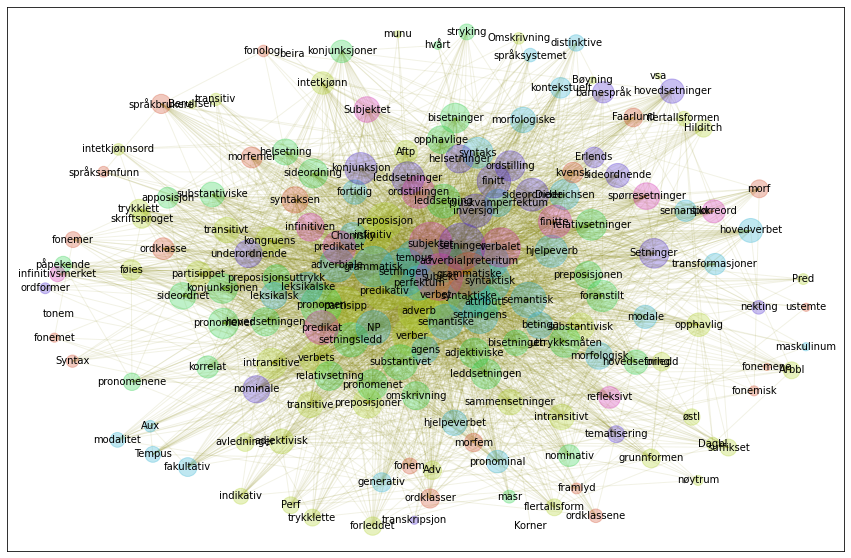

In [177]:
gnl.show_graph(F, spread = 1.8)

Clustrene her ser rimelige ut med tanke på semantiske felt, eller tematiske områder innenfor syntaks. 

Grafen er er det som kommer ut ved å kombinere graf-konstruksjon for de viktigste ordene fra korpuset. Alt gjort per URN på serverside med kommandoen `make_network_graph`, basert på samforekomst av ord i avsnitt .

In [178]:
gnl.show_communities(F)

subjekt-adverbial :  subjekt, adverbial, pronomen, preposisjon, substantivet, setningsledd, leddsetning, attributt, foranstilt, uttrykksmåten, pronomenet, pronomener, adjektiviske, leddsetningen, sideordning, relativsetning, omskrivning, opphavlige, substantivisk, preposisjonen, sideordnet, preposisjonsuttrykk, sammensetninger, substantiviske, Aftp, pronominal, korrelat, nominativ, apposisjon, trykklett, forledd, forleddet, pronomenene, trykklette, Arbbl, flertallsform, påpekende, stryking, flertallsformen, masr, Dagbl, intetkjønnsord, Omskrivning, ordformer, Berulfsen, vsa, tonem

setningen-syntaktiske :  setningen, syntaktiske, syntaktisk, grammatisk, verbalet, tempus, setningens, semantisk, semantiske, adverbiale, preteritum, perfektum, NP, predikat, predikatet, verbets, hjelpeverb, leksikalske, pluskvamperfektum, morfologisk, agens, spørresetninger, leksikalsk, betinga, Chomsky, hjelpeverbet, fortidig, hovedverbet, modale, semantikk, transformasjoner, kontekstuelt, generativ, fakul

For kombinasjon av clustre kan det tenkes at det er bedre å kombinere clustrene fra hver bok på en måte, og lage clustre av clustre. 

## Norsk Ordbank

Det er adgang til norsk ordbank. Også en ressurs vi kanskje kan mekke litt på. Her er det kode for å se på ordformer, paradigmer og lemmaer. Kommandoene kommer i to varianter, en som tar enkeltord og en som tar en liste av ord.

In [3]:
mu.update('wordbank')
import wordbank as wb

Updated file `C:\Users\larsj\Documents\GitHub\Miscellaneous-Notebooks\wordbank.py`

Eksempel på hurtigtagging av en bok

In [217]:
%%time
bok = nb.book_corpus(words=['demokrati'], limit = 1)
print(nb.metadata(bok.urn.values[0]))
bokfreq = nb.get_freq(str(bok.urn.values[0]), top = 0, cutoff = 0)
wb.word_form_many(list(bokfreq.keys()))[:10]

[[2016080109057, '', 1975, 'Planleggingen av morgendagens industrimiljø', 'Trondheim, 6.-8. jan. 1975', 'NIF', '', 'deb78f4e932796b45d3bec9bf068b3f3', 'und', '']]
Wall time: 1.33 s


[['og', 'CLB konj normert'],
 ['og', 'konj normert'],
 ['i', 'prep normert'],
 ['i', 'subst mask appell ent ub normert'],
 ['av', 'fork adj normert'],
 ['av', 'prep normert'],
 ['av', 'henv normert'],
 ['er', 'verb pres <predik1> <predik2> <aux1/perf_part> <adv5> normert'],
 ['som', 'sbu normert'],
 ['det', 'pron pers 3 ent nøyt normert']]

I tillegg til `wb.word_form_many` hent ut lemma og paradigme.

In [218]:
wb.word_lemma_many(list(bokfreq.keys())[100:110])

[['opp', 'prep', 'opp'],
 ['opp', 'verb', 'oppe'],
 ['j', 'subs', 'j'],
 ['bli', 'verb', 'bli'],
 ['system', 'subs', 'system'],
 ['ro', 'verb', 'ro'],
 ['ro', 'verb', 'roe'],
 ['ro', 'subs', 'ro'],
 ['nye', 'adj', 'ny'],
 ['nye', 'verb', 'nye'],
 ['p', 'symb', 'p'],
 ['p', 'fork', 'p.'],
 ['p', 'subs', 'p'],
 ['over', 'prep', 'over'],
 ['muligheter', 'subs', 'mulighet']]

In [219]:
wb.word_paradigm_many(list(bokfreq.keys())[100:110])

[['bli', 'adj', ['blivende', 'blitt', 'blitte']],
 ['bli',
  'verb',
  ['ble', 'blei', 'bli', 'blir', 'blis', 'blitt', 'vart', 'bleiv', 'blev']],
 ['j', 'subs', ['j', "j'en", 'j-en', 'j-ene', 'j-er']],
 ['muligheter',
  'subs',
  ['mulighet', 'muligheta', 'muligheten', 'mulighetene', 'muligheter']],
 ['nye',
  'adj',
  ['ny',
   'nye',
   'nyere',
   'nyest',
   'nyeste',
   'nytt',
   'nya',
   'nyede',
   'nyende',
   'nyet',
   'nyete']],
 ['nye', 'verb', ['ny', 'nya', 'nye', 'nyer', 'nyes', 'nyet']],
 ['opp', 'adj', ['oppa', 'oppede', 'oppende', 'oppet', 'oppete']],
 ['opp', 'prep', ['opp']],
 ['opp', 'verb', ['opp', 'oppa', 'oppe', 'opper', 'oppes', 'oppet']],
 ['over', 'prep', ['over']],
 ['p', 'fork', ['p', 'p.']],
 ['p', 'subs', ['p', "p'en", 'p-en', 'p-ene', 'p-er']],
 ['p', 'symb', ['p']],
 ['ro', 'adj', ['rodd', 'rodde', 'roende', 'roa', 'roede', 'roet', 'roete']],
 ['ro', 'subs', ['ro', 'roa', 'roen', 'roene', 'roer', 'rør', 'rørne']],
 ['ro',
  'verb',
  ['ro', 'rodd', 'ro

Greit å ha, og kan benyttes til en slags baseline-tagging. Så langt ser det ut som om ca. 60 % av ordene i en tekst har entydige tagger.

## Type token ratio

Det er kode for type-token ratio ttr, modellert sånn den følger prinsippene for standardisert ttr, `nb.sttr`.

In [222]:
pm = nb.book_corpus(subject= 'postmodernisme', limit=5)
pm

,urn,author,title,year
0,2013010208026,"Karlsen, Geir",høgskolepedagogisk teoriplattform,1999
1,2008061104030,,Tidens tegn,1989
2,2016070808085,"Melle, Oddbjørn",Utdanning og nasjon i moderniteten,2002
3,2016022408003,,"Musikk, politikk og globalisering",2012
4,2013011606137,"Knutsen, Paul",Analytisk narrasjon,2002


Pandas har tall som objekter som ikke lar seg jsonifisere, så må konvertere til strenger.

In [224]:
urns = [str(x) for x in pm.urn.values]

In [225]:
{x:nb.sttr(x) for x in urns}

{'2013010208026': 0.36428962792131026,
 '2008061104030': 0.368302886286921,
 '2016070808085': 0.4364448265563643,
 '2016022408003': 0.37446942636870406,
 '2013011606137': 0.4050962035964483}

In [227]:
bm = nb.book_corpus(subject= 'barnelitteratur', limit=5)
urns2 = [str(x) for x in bm.urn.values]
bm

,urn,author,title,year
0,2007060400045,"Bondevik, Jarle",Sidsel Sidsærk og Supermann,1975
1,2010042103039,Aesopus,Æsops fabler,1995
2,2016011248084,"Kentley, Eric",Båter,2002
3,2014101506051,"Senje, Siri",Biografien om Camilla Collett,2009
4,2014070206060,"Holm, Dagny",Kampen om Linguana,1993


In [228]:
{x:nb.sttr(x) for x in urns2}

{'2007060400045': 0.4550843924830644,
 '2010042103039': 0.30093586453427923,
 '2016011248084': 0.47019578607087176,
 '2014101506051': 0.3963547484032262,
 '2014070206060': 0.2737724968422575}

Funksjonen for sttr tar to parameter, ett for URN og ett for størrelse på bokbiten. Default er 5000 ord.

In [230]:
sttr = nb.sttr(urns2[0], chunk = 10000)
print(urns2[0], sttr)

2007060400045 0.41546428857239315


## Narrative buer 

Vekstdiagram er en alternativ visualisering til dispersion plots. De er brukt i lokalhistorieforskningen. Henter ut vekstdiagrammet med `nb.plot_book_wordbags(<urn>, <ordsekker>, window=<..>)`. Et eksempel på kode som må gå på serversiden. Vekstdiagrammer kan brukes til tematisk analyse og andre studier av narrativ utvikling.
    
I eksemplet under skal vi forsøke å svare på om det var skadelig å lese Morgan Kane. Hvis glede er knyttet til vold og slagsmål, er det ikke bra, men om gleden er større utenom slåssingen er det bra.
    
Analysen tar utgangspunkt i et sett ord for vold, og ett sett for glede. De kan være håndlaget eller fra andre steder. Her håndlaget.



In [231]:
glede = "glad fornøyd smilende lettet plystret plystre lo latter".split()
vold = "sloss slo skjøt kuler krutt skudd slag spark revolveren geværet".split()

Henter ut vekstdiagrammet med plot_book_wordbags(<urn>, <ordsekker>, window=<..>) og plotter med plot.

In [234]:
mk = nb.book_corpus(author = 'masterson%louis%', limit = 20)
mk

,urn,author,title,year
0,2013071208061,"Masterson, Louis",Hevn!,2011
1,2013070108113,"Masterson, Louis",Kane's kvinner,1974
2,2007053100048,"Masterson, Louis",Død manns skygge,1974
3,2011100608069,"Masterson, Louis","Duell i Tombstone ; Dette er døden, señor Kane",2005
4,2014070106118,"Masterson, Louis",siste cheyenne,1974
5,2007071601101,"Masterson, Louis",Legenden om Morgan Kane,1973
6,2013041608113,"Masterson, Louis",Korset og sverdet,1978
7,2013120238010,"Masterson, Louis",Til siste patron,1991
8,2015102208249,"Masterson, Louis",Kane's colt,1975
9,2016060108117,"Masterson, Louis",Bøddelen fra Guerrero,1973


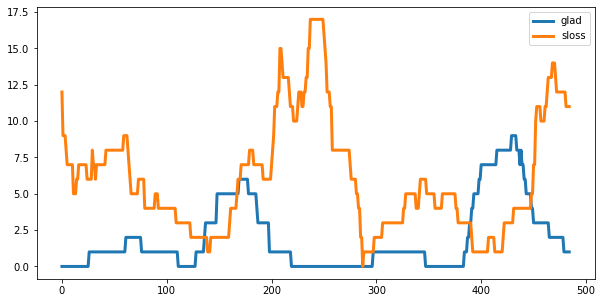

In [236]:
nb.plot_book_wordbags(2013041908133, [glede, vold]).plot(figsize = (10,5), lw = 3)

Basert på de her dataene kan det se ut som Morgan Kane er trygg å lese for barn. Gleden er på topp når volden er på laveste!

## N-gram, galakser og grafer

En viktig ressurs er ngrammene, som kan benyttes til mye. De utgjør også en ressurs for å finne tilsvarende ord, og skulle kunne sammenlignes med word2vec-alternativene. Forskjellen på galakser og word2vec er et galaksene er grafbasert og gir opphave til clustre vi grafanalysen, slik som vi så ovenfor.

Her skal vi se på galaksene og n-gram fra metadata som utgjør et tillegg sammenlignet med webløsningen nb-ngram.

Galaksene henter data fra tjenesten som går på sprakbank-beta, og er de samme som finnes på nett.

In [252]:
G = nb.make_graph('demokrati, Demokrati, demokratiet, Demokratiet', cutoff = 20)

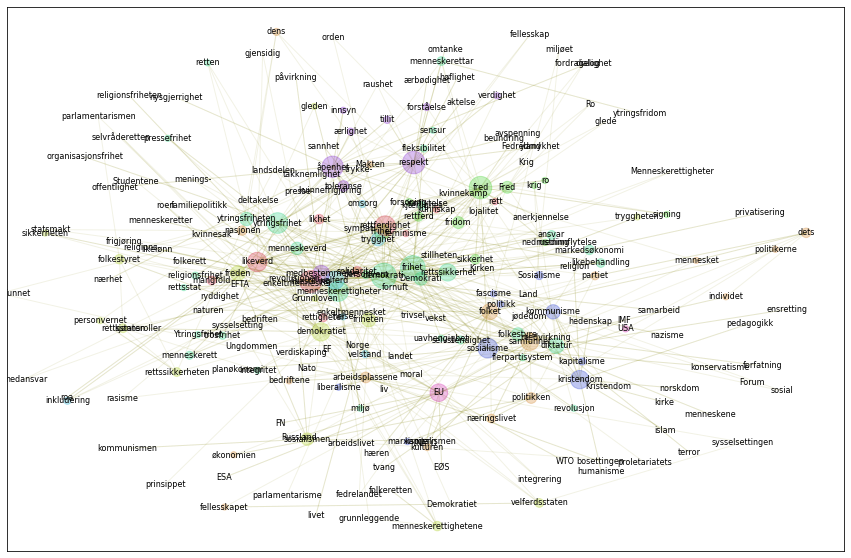

In [256]:
gnl.show_graph(G, spread = 1.2, fontsize=8)

Grupperingene her bør også gi noen semantiske felt, eller temaområder for _demokrati_. Det stemmer rimelig bra. Merk at vi får ut eget -isme-cluster.

In [254]:
gnl.show_communities(G)

demokratiet-freden :  demokratiet, freden, friheten, sosialismen, menneskerettighetene, folkestyret, rettssikkerheten, velferdsstaten, rettsstaten, Grunnloven, tryggheten, sikkerheten, personvernet, gleden, kommunismen, selvråderetten, sysselsettingen, roa, Kirken, fedrelandet, revolusjonen, roen, folkeretten, stillheten, EF, kapitalismen, parlamentarismen, livet, proletariatets, Studentene, prinsippet, Demokratiet

fred-Frihet :  fred, Frihet, Fred, fridom, rettferd, sikkerhet, forsoning, nedrustning, signing, krig, ro, fordragelighet, orden, Krig, Fedreland, avspenning, Ro, glede

demokrati-frihet :  demokrati, frihet, diktatur, Demokrati, folkestyre, menneskeverd, markedsøkonomi, menneskerettar, ansvar, menneskerett, Sosialisme, selvstendighet, kjærlighet, rettsstat, integritet, Ytringsfrihet, revolusjon, flerpartisystem, uavhengighet, Land, forfatning, ensretting, rasisme, privatisering, terror, statsmakt, tvang, menneskeretter, Menneskerettigheter, sosial, ytringsfridom, parlament

I tillegg til clustring er det hjelpefunksjoner som måler sentralitet og relaterte ord tilsvarende w2vec. Det her er kommandoer som i sin helhet går på klientmaskiner, og er gode kandidater for et dedikert grafrepresentasjon.

In [257]:
nb.relaterte_ord('demokrati')

['demokrati',
 'likeverd',
 'menneskerettigheter',
 'frihet',
 'ytringsfrihet',
 'rettssikkerhet',
 'likestilling',
 'rettferdighet',
 'fred',
 'åpenhet',
 'respekt',
 'menneskeverd',
 'sosialisme',
 'toleranse',
 'trygghet',
 'menneskerett',
 'likebehandling',
 'medbestemmelse',
 'folkestyre',
 'velferd']

In [258]:
nb.central_betweenness_characters(G)

[('demokrati', 0.27029067141202034),
 ('demokratiet', 0.1642510284746309),
 ('rettsstaten', 0.12912980739067695),
 ('folket', 0.07751882175795219),
 ('nasjonen', 0.07384286520932483),
 ('sosialisme', 0.07118001969975764),
 ('åpenhet', 0.0687494704198986),
 ('respekt', 0.06772487801183696),
 ('frihet', 0.06261183497667448),
 ('likestilling', 0.05710863222522078)]

In [259]:
nb.central_characters(G)

[('demokrati', 0.21212121212121213),
 ('frihet', 0.20346320346320346),
 ('fred', 0.16883116883116883),
 ('respekt', 0.16883116883116883),
 ('likestilling', 0.16017316017316016),
 ('åpenhet', 0.15151515151515152),
 ('ytringsfrihet', 0.14285714285714285),
 ('menneskerettigheter', 0.1341991341991342),
 ('rettferdighet', 0.1341991341991342),
 ('sosialisme', 0.12987012987012986)]

## NER og